In [18]:
import link_bot_classifiers
from link_bot_data.classifier_dataset import ClassifierDataset
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import json
from moonshine.gpu_config import limit_gpu_mem
from link_bot_pycommon.get_scenario import get_scenario
import link_bot_classifiers
from link_bot_data.link_bot_dataset_utils import add_planned
from scipy import stats

plt.style.use("slides")
np.set_printoptions(suppress=True, linewidth=250)
limit_gpu_mem(1)

## Dataset

In [2]:
dataset_dirs = [pathlib.Path("classifier_data/rope_relaxed_mer/")]
classifier_dataset = ClassifierDataset(dataset_dirs)
tf_dataset = classifier_dataset.get_datasets(mode='test', take=100)

## Model

In [3]:
checkpoint = pathlib.Path("log_data/rope_rnn_lr=0.0001/May_12_12-09-06_7acb2e27c8")
model_hparams = json.load((checkpoint / 'hparams.json').open('r'))
model = link_bot_classifiers.get_model(model_hparams['model_class'])
scenario = get_scenario(classifier_dataset.hparams['scenario'])
net = model(hparams=model_hparams, batch_size=1, scenario=scenario)

In [16]:
all_total_stdevs = []
all_labels = []
total_stdevs_positive = []
total_stdevs_negative = []
for i, example in enumerate(tf_dataset):
    last_valid_idx = int(example['last_valid_idx'].numpy().squeeze())
    stdevs = example[add_planned('stdev')].numpy().squeeze()
    valid_stdevs = stdevs[:last_valid_idx + 1]
    label = example['label'].numpy().squeeze()
    total_stdev = sum(valid_stdevs)
    all_total_stdevs.append(total_stdev)
    all_labels.append(label)
    if label:
        total_stdevs_negative.append(total_stdev)
    else:
        total_stdevs_positive.append(total_stdev)

Text(0, 0.5, 'label')

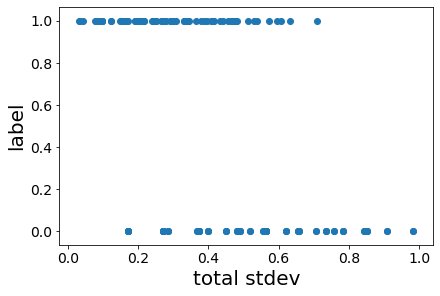

In [14]:
plt.scatter(all_total_stdevs, all_labels)
plt.xlabel("total stdev")
plt.ylabel("label")

In [25]:
kernel_negative = stats.gaussian_kde(total_stdevs_negative)
kernel_positive = stats.gaussian_kde(total_stdevs_positive)
stdev_samples = np.linspace(0, 1, 100)
density_negative = kernel_negative(stdev_samples)
density_positive = kernel_positive(stdev_samples)

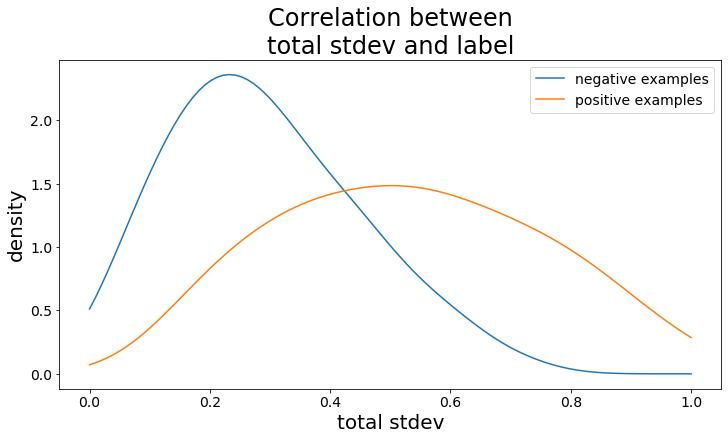

In [35]:
plt.figure(figsize=(10,6))
plt.plot(stdev_samples, density_negative, label='negative examples')
plt.plot(stdev_samples, density_positive, label='positive examples')
plt.xlabel("total stdev")
plt.ylabel("density")
plt.title("Correlation between\ntotal stdev and label")
plt.legend();